# Test 2

In [91]:
import hashlib
import os
import requests
import re
import collections
import random
import torch
from torch import nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import zipfile

torch.manual_seed(42);
torch.backends.cudnn.deterministic = True

# Exercise 1

In [46]:
ex1_input_size = 7
ex1_hidden_size = 5

In [47]:
ex1_net = nn.RNN(ex1_input_size, ex1_hidden_size, 3)

In [48]:
ex1_input = torch.normal(0.0, 0.7, (15, 1, 7))
ex1_state = torch.ones((3, 1, 5))

In [49]:
ex1_output, ex1_state_new = ex1_net(ex1_input, ex1_state)
ex1_output.shape, ex1_state_new.shape

(torch.Size([15, 1, 5]), torch.Size([3, 1, 5]))

In [50]:
ex1_output, ex1_state_new

(tensor([[[-0.8846,  0.1483, -0.5639,  0.3649, -0.6121]],
 
         [[-0.1821,  0.0133, -0.1746,  0.8209, -0.5587]],
 
         [[-0.6556,  0.4714, -0.1979,  0.6341, -0.5350]],
 
         [[-0.6158,  0.1043, -0.3780,  0.6988, -0.6047]],
 
         [[-0.5831,  0.4527, -0.0186,  0.6706, -0.5433]],
 
         [[-0.5453, -0.1119, -0.5022,  0.7499, -0.6167]],
 
         [[-0.4512,  0.4416, -0.1505,  0.7566, -0.5026]],
 
         [[-0.7996,  0.3105, -0.1872,  0.5975, -0.6230]],
 
         [[-0.5893,  0.1074, -0.2978,  0.6819, -0.6096]],
 
         [[-0.7367,  0.3344, -0.1405,  0.5090, -0.6384]],
 
         [[-0.6088,  0.2981, -0.1001,  0.6144, -0.5028]],
 
         [[-0.2703,  0.0925, -0.3494,  0.7920, -0.5498]],
 
         [[-0.5151,  0.3296, -0.2561,  0.7453, -0.6192]],
 
         [[-0.5331,  0.1974, -0.3821,  0.7796, -0.5441]],
 
         [[-0.7135,  0.4461, -0.0315,  0.6100, -0.6537]]],
        grad_fn=<StackBackward0>),
 tensor([[[ 0.1098,  0.1030, -0.2941,  0.3475,  0.3367]],
 
      

# Exercise 2

## Data

In [19]:
from typing import Literal, List

In [37]:
def download(url: str) -> str:
    """Download a file, return the local filename."""
    os.makedirs('../data', exist_ok=True)
    file_path = '../data/' + url.split('/')[-1]
    if os.path.exists(file_path):
        return file_path
    
    print(f'Downloading {file_path} from {url}...')
    res = requests.get(url, stream=True, verify=True)
    with open(file_path, 'wb') as f:
        f.write(res.content)
    return file_path

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    file = download('https://s3.amazonaws.com/text-datasets/nietzsche.txt')
    with open(file, 'r') as f:
        lines = f.readlines()
    
    lines_transformed = [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
    return [line for line in lines_transformed if line]

def tokenize(lines: List[str], token: Literal['word', 'char']='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        tokens: list[list[str]] =  [line.split() for line in lines]
    else:
        tokens: list[list[str]] = [list(line) for line in lines]
    return [token for sublist in tokens for token in sublist]
    
def count_corpus(tokens: List[str]):
    """Count token frequencies."""
    return collections.Counter(tokens)

In [35]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens: List[str]=[], min_freq=0, reserved_tokens: List[str]=[]):
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens + [token for token, freq in self._token_freqs if freq >= min_freq]
        self.token_to_idx =  {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self) -> int:
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.token_to_idx.get(token, self.unk) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self) -> Literal[0]:  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Token frequencies
        return self._token_freqs


class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size: int, num_steps: int, max_tokens: int=10000):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.vocab = self.generate_vocab()
        self.corpus = self.generate_corpus(max_tokens)
        
    def generate_vocab(self) -> Vocab:
        lines = read_time_machine()
        tokens = tokenize(lines, 'char')
        return Vocab(tokens)
    
    def generate_corpus(self, max_tokens):
        tokens = tokenize(read_time_machine(), 'char')
        corpus = [self.vocab[token] for line in tokens for token in line]
        return corpus[:max_tokens]

    def __iter__(self):
        """Generate a mini-batch of subsequences using sequential partitioning."""
        # Start with a random offset to partition a sequence
        offset = random.randint(0, self.num_steps)
        num_tokens = ((len(self.corpus) - offset - 1) // self.batch_size) * self.batch_size
        Xs = torch.tensor(self.corpus[offset: offset + num_tokens])
        Ys = torch.tensor(self.corpus[offset + 1: offset + 1 + num_tokens])
        Xs, Ys = Xs.reshape(self.batch_size, -1), Ys.reshape(self.batch_size, -1)
        num_batches = Xs.shape[1] // self.num_steps
        for i in range(0, self.num_steps * num_batches, self.num_steps):
            X = Xs[:, i: i + self.num_steps]
            Y = Ys[:, i: i + self.num_steps]
            yield X, Y

In [39]:
ex2_batch_size = 32
ex2_num_steps = 20

ex2_train_iter = SeqDataLoader(ex2_batch_size, ex2_num_steps)
ex2_vocab = ex2_train_iter.vocab

In [40]:
ex2_input_size = len(ex2_vocab)
ex2_hidden_size = 64

## Model

In [41]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                 device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [44]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

device = try_gpu()

In [45]:
ex2_lstm = nn.LSTM(ex2_input_size, ex2_hidden_size)
ex2_net = RNNModel(ex2_lstm, ex2_input_size)
ex2_net = ex2_net.to(device)

## Training

In [51]:
def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [52]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [53]:
def train_epoch(net, train_iter, loss, optimizer, device):
    """Train a net within one epoch."""
    state = None
    # Sum of training loss, no. of tokens
    total_loss = 0
    total_tokens = 0
    for X, Y in train_iter:
        if state is None:
            # Initialize `state` when it is the first iteration
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM`
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        optimizer.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        total_loss += float(l * y.numel())
        total_tokens += y.numel()
    return math.exp(total_loss / total_tokens)

In [56]:
def train(net, train_iter, vocab, lr, num_epochs, device):
    """Train a model."""
    loss = nn.CrossEntropyLoss()
    perplexities = []
    # Initialize
    optimizer = torch.optim.SGD(net.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch(
            net, train_iter, loss, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(predict('truth', 50, net, vocab, device))
            perplexities.append(ppl)
    print(f'perplexity {ppl:.1f}, device {str(device)}')
    print(predict('truth', 50, net, vocab, device))

    return perplexities

In [57]:
ex2_lr = 1.5
ex2_epochs = 200
perplexities = train(ex2_net, ex2_train_iter, ex2_vocab, ex2_lr, ex2_epochs, device)

truthe the the the the the the the the the the the the 
truth and the the the the the the the the the the the t
truth and the were to the were to the were to the were 
truth and the probe to the sond and the probe to the so
truth as the were of the were of the were of the were o
truth and a dogn and the to inse to the grand of the pr
truth as the wat the probelf there and the wander the t
truth as the wall the truth which as all the truth is t
truth as a predant the has in and the probelf there and
truth and a diger and a philosophers and theinge that t
truthess and the perseds of the with the ground will to
truth as and the grale that the most timesout the itsel
truth and dist and as to the pall than the grould they 
truthess and whoche and a philiof oppirat of ittesess a
truth as in is really speiles instinctinct and who han 
truth as it it were been a hioh all physible the strang
truth the spiting in a all then a proull the strange st
truth such as the sor galue of this will to the 

## Plotting

In [58]:
def plot_perplexity(perplexities):
    epochs = range(10, len(perplexities * 10) + 1, 10)
    plt.plot(epochs, perplexities, 'b', label='Train perplexity') 
    plt.title('Training perplexity') 
    plt.xlabel('Epochs') 
    plt.ylabel('Perplexity') 
    plt.legend()  
    plt.show()

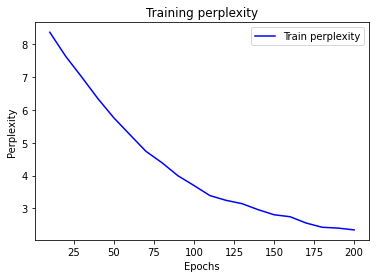

In [59]:
plot_perplexity(perplexities)

# Exercise 3

In [60]:
def f(x):
    return 2 * torch.tanh(x) - x

In [82]:
n = 150
x_train, _ = torch.sort(torch.rand(n) * 15 - 7)

In [83]:
eps = torch.normal(0, 0.6, size=(n,))
y_train = f(x_train) + eps

In [84]:
x_test = torch.arange(-7, 8, 0.1)
y_test = f(x_test)

## Plotting

In [65]:
from matplotlib import pyplot as plt


def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_test, label='Truth')
    plt.plot(x_test, y_hat, label='Pred')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.plot(x_train, y_train, 'o', alpha=0.5);

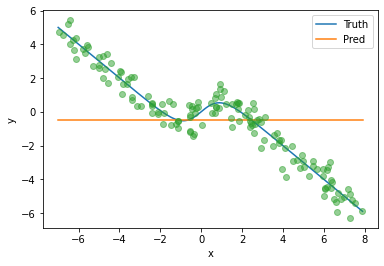

In [85]:
y_hat = torch.repeat_interleave(y_train.mean(), n)
plot_kernel_reg(y_hat)

In [86]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

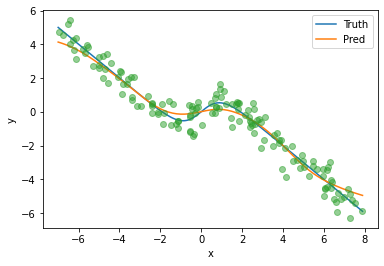

In [88]:
X_repeat = x_test.repeat_interleave(n).reshape((-1, n))
# Note that `x_train` contains the keys. Shape of `attention_weights` is:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`), given each query
attention_weights = F.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# Each element of `y_hat` is a weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

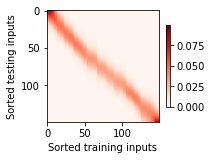

In [89]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')

# Exercise 4

## Data

In [90]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Token frequencies
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(url, folder=None):
    """Download and extract a zip file."""
    fname = download(url)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    else:
        assert False, 'Only zip files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = download_extract('http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into mini-batches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [92]:
ex4_batch_size = 32
ex4_num_steps = 5

ex4_train_iter, ex4_src_vocab, ex4_tgt_vocab = load_data_nmt(ex4_batch_size, ex4_num_steps)

## Model

In [139]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [140]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return F.softmax(X.reshape(shape), dim=-1)

In [141]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries` is: (`batch_size`, no. of queries, `d`)
    # Shape of `keys` is: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values` is: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Use `keys.transpose(1,2)` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [142]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [143]:
class AttentionDecoder(Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [144]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [145]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [146]:
def transpose_qkv(X, num_heads):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input `X` is:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X` is:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # Shape of output `X` is:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # Shape of `output` is:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`."""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [147]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of `queries`, `keys`, or `values` is:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens` is:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values` is:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of `output` is: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # Shape of `output_concat` is:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [148]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [149]:
class PositionWiseFFN(nn.Module):
    """Position-wise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [165]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [175]:
class Network(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, dropout, **kwargs):
        super(Network, self).__init__(**kwargs)
        self.dense1 = nn.Linear(num_inputs, num_hiddens)
        self.dropout1 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(num_hiddens, num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, X):
        Y = self.relu(self.dropout1(self.dense1(X)))
        return self.dropout2(self.dense2(Y))

In [167]:
class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.nn = Network(ffn_num_input, ffn_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.nn(self.addnorm2(Y, self.ffn(Y)))

In [152]:
class TransformerEncoder(Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [168]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        self.nn = Network(ffn_num_input, ffn_num_hiddens, num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens` is: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs` is:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.nn(self.addnorm3(Z, self.ffn(Z))), state

In [154]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [177]:
ex4_dropout = 0.5
ex_num_units = 32
ex4_num_hidden = 32
key_size, query_size, value_size = 32, 32, 32
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
norm_shape = [32]
ex4_n = 1

encoder = TransformerEncoder(
    len(ex4_src_vocab), key_size, query_size, value_size, ex4_num_hidden,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    ex4_n, ex4_dropout)

decoder = TransformerDecoder(
    len(ex4_tgt_vocab), key_size, query_size, value_size, ex4_num_hidden,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    ex4_n, ex4_dropout)

ex4_net = EncoderDecoder(encoder, decoder)

## Training

In [156]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [157]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    train_loss_all = []
    for epoch in range(num_epochs):
        # Sum of training loss, no. of tokens
        total_loss = 0
        total_tokens = 0
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                total_loss += l.sum()
                total_tokens += num_tokens
        if (epoch + 1) % 10 == 0:
            train_loss_all.append(total_loss / total_tokens)
    print(f'loss {total_loss / total_tokens:.3f}, device {str(device)}')
    
    return train_loss_all

In [178]:
ex4_lr = 0.005
ex4_num_epochs = 150
train_loss_all = train_seq2seq(ex4_net, ex4_train_iter, ex4_lr, ex4_num_epochs, ex4_tgt_vocab, device) #1 min

loss 0.431, device cpu


## Plotting

In [179]:
def plot_loss(train_loss_all):
    train_loss_all = [train_loss.cpu() for train_loss in train_loss_all]
    epochs = range(10, len(train_loss_all * 10) + 1, 10)
    plt.plot(epochs, train_loss_all, 'b', label='Train loss') 
    plt.title('Training loss') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.legend()  
    plt.show()

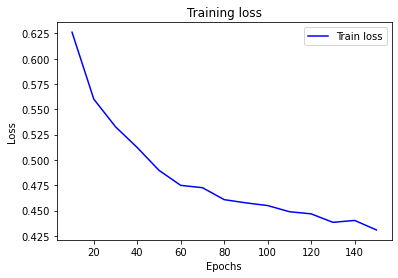

In [180]:
plot_loss(train_loss_all)